# 🎓 Global Tech University Admissions Optimizer

This notebook builds a decision-support tool to help GTU predict admissions probability and scholarship eligibility based on historical data.

In [14]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [15]:
# 📥 Load Data
# Replace with your actual file path or upload via Colab
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)))
df.head()

Saving Admission_Predict.csv to Admission_Predict (2).csv


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [16]:
# 🧹 Data Preprocessing
df = df.dropna()
df = df.rename(columns=lambda x: x.strip().replace(" ", "_"))

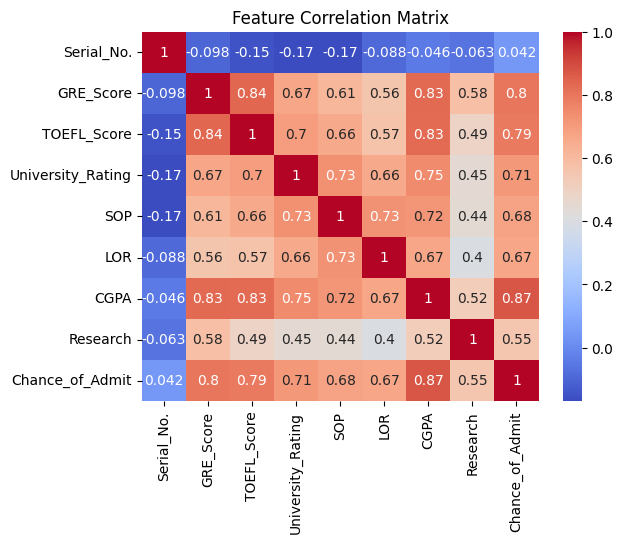

In [17]:
# 📊 Exploratory Data Analysis
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [18]:
# 📈 Multicollinearity Check
X_vif = sm.add_constant(df.drop(columns=['Chance_of_Admit']))
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data

,feature,VIF
0,const,1533.435012
1,Serial_No.,1.087496
2,GRE_Score,4.617117
3,TOEFL_Score,4.357634
4,University_Rating,2.959083
5,SOP,3.113171
6,LOR,2.432982
7,CGPA,5.419519
8,Research,1.543329


In [19]:
# 🧠 Linear Regression
X = df.drop(columns=["Chance_of_Admit"])
y = df["Chance_of_Admit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("R² (Linear Regression):", r2_score(y_test, y_pred_lr))

R² (Linear Regression): 0.8212241793299226


In [20]:
# 🌳 Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
params_dt = {"max_depth": [3, 5, 10], "min_samples_split": [2, 5, 10]}
grid_dt = GridSearchCV(dt, params_dt, cv=5)
grid_dt.fit(X_train, y_train)
y_pred_dt = grid_dt.predict(X_test)
print("R² (Tuned Decision Tree):", r2_score(y_test, y_pred_dt))

R² (Tuned Decision Tree): 0.8057112848116956


In [21]:
# 🌲 Random Forest Regressor with Tuning
rf = RandomForestRegressor(random_state=42)
params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_rf = RandomizedSearchCV(rf, params_rf, n_iter=10, cv=3, random_state=42)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
print("R² (Tuned Random Forest):", r2_score(y_test, y_pred_rf))

R² (Tuned Random Forest): 0.8560077883951225


In [22]:
# ⭐ Feature Importance and Top 5 Feature Modeling
importances = grid_rf.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({"feature": X.columns, "importance": importances})
top5 = feature_importance_df.sort_values(by="importance", ascending=False).head(5)["feature"].tolist()
print("Top 5 features:", top5)

# Retrain with Top 5 features
X_top5 = df[top5]
X_train_top5, X_test_top5, y_train, y_test = train_test_split(X_top5, y, test_size=0.2, random_state=42)
rf_top5 = RandomForestRegressor(random_state=42)
rf_top5.fit(X_train_top5, y_train)
y_pred_top5 = rf_top5.predict(X_test_top5)
print("R² (Random Forest with Top 5):", r2_score(y_test, y_pred_top5))

Top 5 features: ['CGPA', 'GRE_Score', 'Serial_No.', 'TOEFL_Score', 'SOP']
R² (Random Forest with Top 5): 0.8512470165396518
